In [26]:
from pathlib import Path

import pandas as pd
import polars as ps
import seaborn as sb

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Data Preprocessing

## Load Datasets

In [28]:
type_map: list = [ps.Utf8, ps.Utf8, ps.Int32, ps.Utf8, ps.Utf8, ps.Float32, ps.Float32, 
                  ps.Float32, ps.Float32, ps.Float32, ps.Float32, ps.Float32, ps.Float32, 
                  ps.Float32, ps.Float32, ps.Float32, ps.Float32, ps.Float32, ps.Int32,
                  ps.Datetime, ps.Float32, ps.Float32, ps.Float32, ps.Int32]
null_values: list = ['', '-']

In [29]:
dataset_type: str = 'train'
datasets: list = [
	ps.read_csv(file, encoding='utf8', dtypes=type_map, null_values=null_values, n_threads=8, use_pyarrow=True)
	for file in Path('data/{}'.format(dataset_type)).glob('*.csv')]
dataset: ps.DataFrame = ps.concat(datasets)

## Remove Duplicate Rows and Add New Column

In [30]:
dataset = dataset.unique()
dataset = dataset.with_columns(ps.col('PublishTime').dt.strftime('%Y-%m').alias('PublishYearAndMonth'))

## Convert Non-numerical Data to Numbers

In [31]:
dataset['County'].value_counts(sort=True)

County,counts
str,u32
"""新北市""",193702
"""高雄市""",183183
"""臺北市""",112730
"""桃園市""",92530
"""臺中市""",76110
"""臺南市""",69482
"""雲林縣""",61066
"""彰化縣""",53641
"""屏東縣""",53619


In [32]:
county_type: list = dataset['County'].value_counts(sort=True)['County'].to_list()
county_map: dict = dict(zip(county_type, [i for i in range(len(county_type))]))

In [33]:
dataset = dataset.with_columns(
	ps.col('County').map_dict(county_map, default='unknown').alias('County').cast(ps.Int32, strict=False))

In [34]:
dataset['Pollutant'].value_counts(sort=True)

Pollutant,counts
str,u32
null,758757
"""細懸浮微粒""",394179
"""臭氧八小時""",46944
"""二氧化氮""",9469
"""懸浮微粒""",8893
"""二氧化硫""",128
"""臭氧""",9
"""一氧化碳""",2


In [35]:
pollutant_type: list = dataset['Pollutant'].value_counts(sort=True)['Pollutant'].to_list()
pollutant_type.remove(None)
pollutant_map: dict = dict(zip(pollutant_type, [i for i in range(len(pollutant_type))]))

In [36]:
dataset = dataset.with_columns(
	ps.col('Pollutant').map_dict(pollutant_map, default='unknown').alias('Pollutant').cast(ps.Int32, strict=False))

In [37]:
dataset['Status'].value_counts(sort=True)

Status,counts
str,u32
"""良好""",755203
"""普通""",385681
"""對敏感族群不健康""",64309
"""對所有族群不健康""",9610
null,3554
"""非常不健康""",22
"""危害""",2


In [38]:
status_type: list = dataset['Status'].value_counts(sort=True)['Status'].to_list()
status_type.remove(None)
status_map: dict = dict(zip(status_type, [i for i in range(len(status_type))]))

In [39]:
dataset = dataset.with_columns(
	ps.col('Status').map_dict(status_map, default='unknown').alias('Status').cast(ps.Int32, strict=False))

## Fill Missing Values

In [40]:
dataset.null_count()

SiteName,County,AQI,Pollutant,Status,SO2,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,PM2.5,PM2.5_AVG,NO2,NOx,NO,WindSpeed,WindDirec,PublishTime,SO2_AVG,Longitude,Latitude,SiteId,PublishYearAndMonth
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,4500,758757,3554,26661,28101,17624,37485,22618,27914,16777,24383,13266,31769,31942,31897,268991,268863,0,11399,0,0,0,0


In [41]:
dataset: pd.DataFrame = dataset.to_pandas(use_pyarrow_extension_array=True)

In [42]:
processed_columns: list = ['AQI', 'Pollutant', 'Status', 'WindDirec']
for column in processed_columns:
	dataset[column] = dataset.groupby(['County', 'PublishYearAndMonth'])[column] \
		.transform(lambda group: group.fillna(group.median()) if not group.isnull().all()
	else group.fillna(dataset[column].median()))

In [43]:
processed_columns: list = ['SO2', 'SO2_AVG', 'CO', 'CO_8hr', 'O3', 'O3_8hr', 'PM10', 'PM10_AVG', 'PM2.5', 'PM2.5_AVG', 'NO2', 'NOx', 'NO', 'WindSpeed']
for column in processed_columns:
	dataset[column] = dataset.groupby(['County', 'PublishYearAndMonth'])[column] \
		.transform(lambda group: group.fillna(group.mean()) if not group.isnull().all()
	else group.fillna(dataset[column].mean()))

In [44]:
dataset: ps.DataFrame = ps.from_pandas(dataset)

In [45]:
type_map.append(ps.Utf8)
type_map[1], type_map[3], type_map[4] = ps.Int32, ps.Int32, ps.Int32
for i, column in enumerate(dataset.columns):
	dataset = dataset.with_columns(ps.col(column).cast(type_map[i], strict=False))
	if type_map[i] is ps.Float32:
		dataset = dataset.with_columns(ps.col(column).round(1))

# Data Analysis

In [46]:
dataset = dataset.with_columns(ps.col('PublishTime').dt.year().cast(ps.Int32).alias('PublishYear'))
dataset = dataset.with_columns(ps.col('PublishTime').dt.month().cast(ps.Int32).alias('PublishMonth'))
dataset = dataset.with_columns(ps.col('PublishTime').dt.day().cast(ps.Int32).alias('PublishDay'))
dataset = dataset.with_columns(ps.col('PublishTime').dt.hour().cast(ps.Int32).alias('PublishHour'))

In [47]:
dataset = dataset.drop(['SiteName', 'County', 'PublishTime', 'PublishYearAndMonth', 'Longitude', 'Latitude'])
dataset = dataset.unique()
dataset = dataset[['SiteId', 'PublishYear', 'PublishMonth', 'PublishDay', 'PublishHour', 
                   'AQI', 'Pollutant', 'Status', 'SO2', 'SO2_AVG', 'CO', 'CO_8hr', 'O3', 
                   'O3_8hr', 'PM10', 'PM10_AVG', 'NO', 'NO2', 'NOx', 'WindDirec', 
                   'WindSpeed', 'PM2.5', 'PM2.5_AVG']]

In [48]:
dataset.write_csv('full_dataset_{}.csv'.format(dataset_type))

In [49]:
dataset

SiteId,PublishYear,PublishMonth,PublishDay,PublishHour,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5,PM2.5_AVG
i32,i32,i32,i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
15,2022,6,1,0,37,1,0,1.6,1.0,0.6,0.4,0.1,5.4,15.0,11.0,9.2,22.5,31.799999,31,0.3,6.0,5.0
28,2022,6,1,0,16,0,0,0.6,0.0,0.2,0.1,15.3,16.799999,19.0,16.0,0.6,2.1,2.7,179,0.7,5.0,4.0
54,2022,6,1,1,22,0,0,1.8,1.0,0.2,0.1,3.6,13.7,15.0,12.0,0.6,12.8,13.4,262,1.7,7.0,6.0
52,2022,6,1,3,23,0,0,0.5,0.0,0.1,0.1,16.0,15.3,15.0,23.0,1.1,5.3,6.4,180,0.8,1.0,4.0
48,2022,6,1,3,26,0,0,1.0,1.0,0.2,0.1,1.1,7.4,28.0,21.0,2.6,13.2,15.8,88,1.3,11.0,8.0
70,2022,6,1,4,13,1,0,0.3,0.0,0.2,0.5,6.0,4.9,21.0,13.0,1.8,5.1,7.0,140,0.8,2.0,3.0
13,2022,6,1,5,20,1,0,0.3,0.0,0.2,0.3,7.0,4.3,14.0,10.0,0.8,5.4,6.2,127,0.6,7.0,6.0
77,2022,6,1,7,18,0,0,0.0,0.0,0.1,0.0,7.1,9.3,5.0,10.0,2.1,11.0,13.2,216,2.5,4.0,3.0
36,2022,6,1,9,21,1,0,1.5,0.0,0.2,0.1,19.4,6.6,21.0,21.0,2.7,4.1,6.8,203,1.5,4.0,6.0


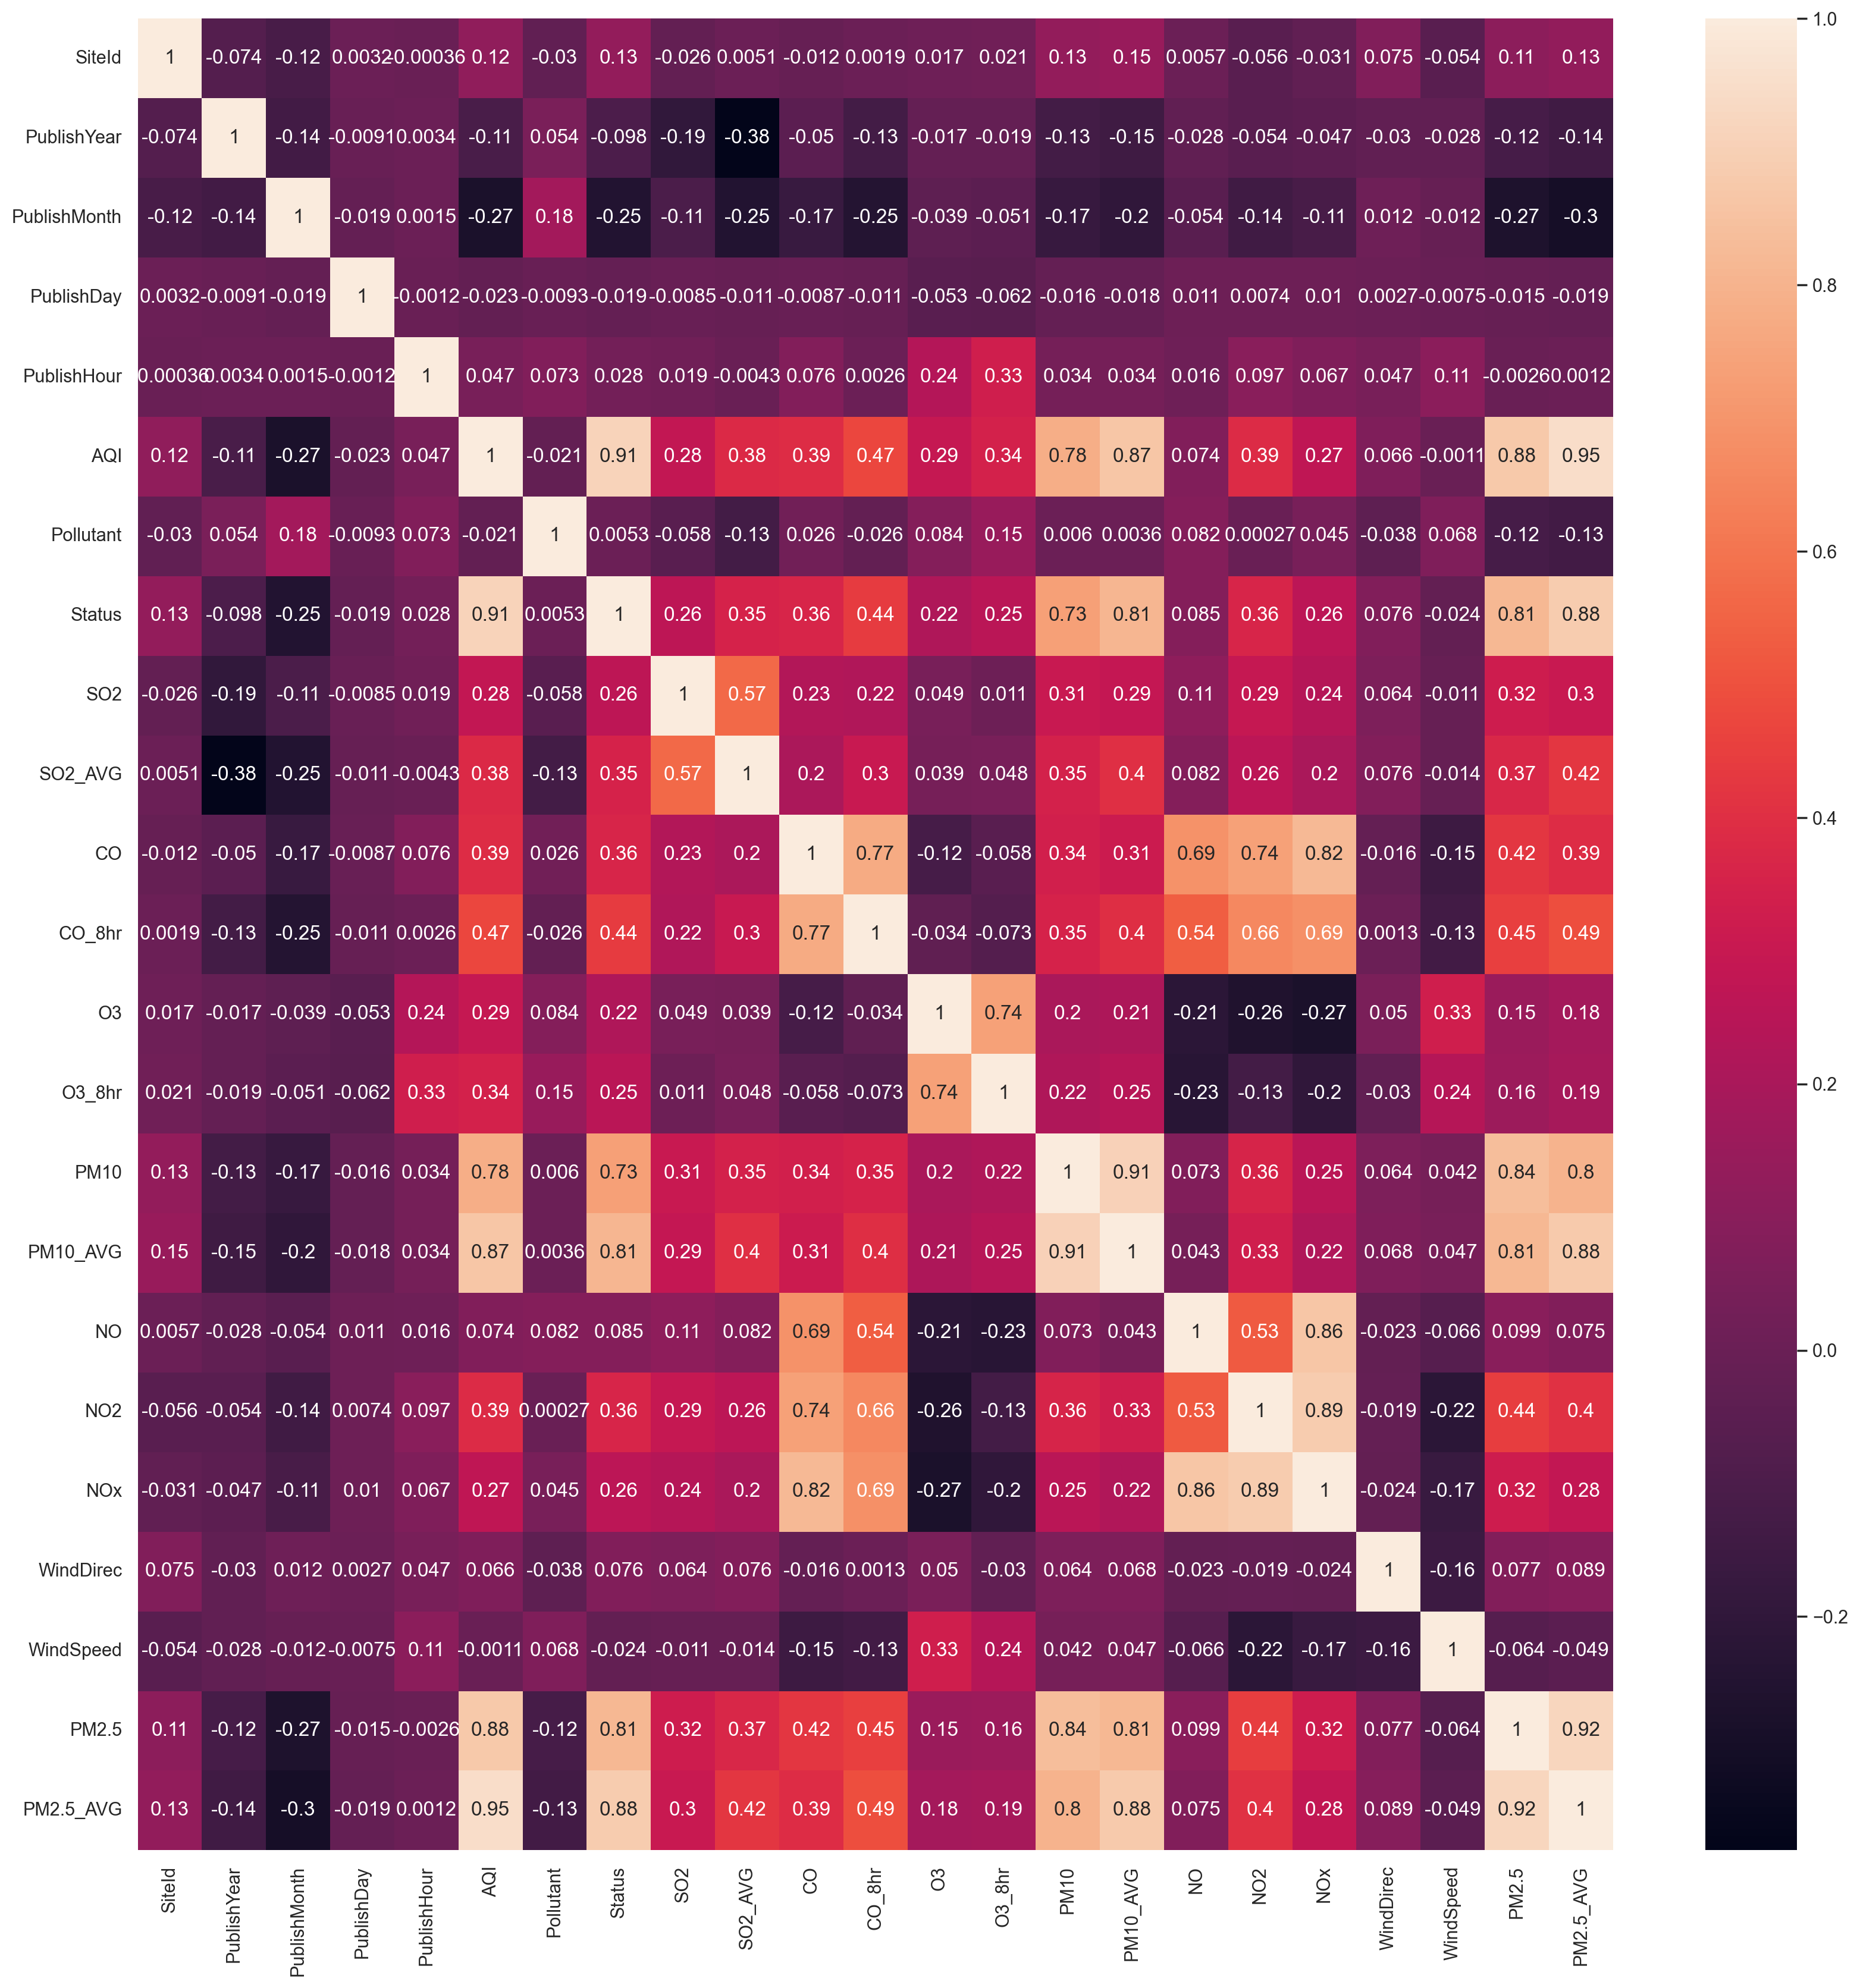

In [50]:
if dataset_type == 'train':
	sb.set(rc={'figure.figsize': (20, 20)})
	sb.heatmap(dataset.to_pandas(use_pyarrow_extension_array=True).corr(), annot=True)